# ML4SA Lab 2: Unsupervised data exploration

In [1]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
YEAR = 2021
MAX_PER_CLASS = 200
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 25
UMAP_MIN_DIST = 0.1
SCALE = 100
SAMPLES_PER_CLASS_RAW = 500
MAX_PER_CLASS_FINAL = 300
MAX_PER_CLASS_TILE = 200
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

d:\studia\Y5S1\ML_for_Space_Tech_2\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)



## 1: Construct a large, distributed, balanced GEF/CORINE dataset

I'll go for 

In [2]:
region = (
    ee.FeatureCollection('FAO/GAUL/2015/level2')
    .filter(ee.Filter.eq('ADM2_NAME', 'Krakow'))
    .geometry()
)

# Annual Satellite Embedding (example: 2021)
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2021-01-01','2022-01-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

# Visualize (pseudo-RGB from embedding bands)
m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

# Adds the CORINE raster to the map, colored according to EEA’s palette
m.addLayer(clc_idx, corine.vis, 'CORINE 2018')

# Creates a scrollable legend showing all 44 class names with their corresponding colors.
legend = m.add_legend(title="CORINE Land Cover 2018", legend_dict=corine.legend_dict)

m

Map(center=[50.055221250128405, 19.99875758870854], controls=(WidgetControl(options=['position', 'transparent_…

Going for Kraków, including Balice Airport

In [3]:
aoi_proper = region

In [4]:
# GSE
emb_img = (
    ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    .filterDate(f'{YEAR}-01-01', f'{YEAR+1}-01-01')
    .filterBounds(aoi_proper)
    .mosaic()
    .clip(aoi_proper)
)

emb_bands = [f"A{i:02d}" for i in range(64)]
emb_img = emb_img.select(emb_bands)


In [5]:
clc_raw = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(aoi_proper)


clc_idx = clc_raw.rename('landcover_idx')


mask = clc_idx.gt(0)

emb_masked = emb_img.updateMask(mask)
stack = emb_masked.addBands(clc_idx)


classes_img = clc_idx.updateMask(mask)
present_idx = (
    classes_img
    .reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=aoi_proper,
        scale=SCALE,
        maxPixels=1e9
    )
    .get('landcover_idx')
)

present_idx = ee.Dictionary(present_idx).keys().map(lambda x: ee.Number.parse(x))
present_idx = present_idx.getInfo()
present_idx = sorted(set(int(v) for v in present_idx))

In [6]:
def sample_class(idx):
    img = stack.updateMask(clc_idx.eq(idx))
    return img.sample(
        region=aoi_proper,
        scale=SCALE,
        numPixels=SAMPLES_PER_CLASS_RAW,
        seed=RANDOM_SEED,
        geometries=True,
    )

# Use a single stratifiedSample to avoid too many concurrent aggregations.
# Requests SAMPLES_PER_CLASS_RAW points for each class present in 'present_idx'.
samples_fc = stack.stratifiedSample(
    numPoints=0,
    classBand='landcover_idx',
    region=aoi_proper,
    scale=SCALE,
    seed=RANDOM_SEED,
    geometries=True,
    classValues=present_idx,
    classPoints=[SAMPLES_PER_CLASS_RAW] * len(present_idx),
)

# Retrieve features in chunks to avoid EE's 5000-element client-side limit.
fc_size = samples_fc.size().getInfo()
chunk_size = 1000  # keep under 5000
rows = []

for offset in range(0, fc_size, chunk_size):
    chunk = samples_fc.toList(chunk_size, offset).getInfo()
    for f in chunk:
        props = f["properties"].copy()
        geom = f["geometry"]

        if geom["type"] == "Point":
            lon, lat = geom["coordinates"]
        else:
            coords = np.array(geom["coordinates"][0])
            lon = coords[:, 0].mean()
            lat = coords[:, 1].mean()

        props["longitude"] = lon
        props["latitude"] = lat
        rows.append(props)

df = pd.DataFrame(rows)
df = df.dropna().reset_index(drop=True)

print("Columns in df:", df.columns.tolist())
print(df.head())

Columns in df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'longitude', 'latitude']
        A00       A01       A02       A03       A04       A05       A06  \
0 -0.004983 -0.267958  0.051734 -0.141730  0.093564 -0.251965 -0.051734   
1 -0.012057 -0.259900  0.066990 -0.186082  0.113741 -0.206936 -0.041584   
2  0.029773 -0.336855 -0.029773 -0.192910  0.103406 -0.113741  0.044844   
3 -0.027128 -0.267958  0.135886 -0.199862  0.059116 -0.214133 -0.024606   
4 -0.041584 -0.310096  0.059116 -0.166336  0.088827 -0.236463 -0.084214   

        A07       A08       A09  ...       

In [7]:
import h3

cols = df.columns.tolist()
print("Columns in df:", cols)

lat_col, lon_col = "latitude", "longitude"


if hasattr(h3, "geo_to_h3"):

    def cell_fn(lat, lon, res):
        return h3.geo_to_h3(lat, lon, res)
    def parent_fn(h, res):
        return h3.h3_to_parent(h, res)
else:

    def cell_fn(lat, lon, res):
        return h3.latlng_to_cell(lat, lon, res)
    def parent_fn(h, res):
        return h3.cell_to_parent(h, res)

def latlon_to_h3(row, res):
    return cell_fn(row[lat_col], row[lon_col], res)


df["h3_z6"] = df.apply(lambda r: latlon_to_h3(r, 6), axis=1)


df["h3_z4"] = df["h3_z6"].apply(lambda h: parent_fn(h, 4))

print(df[["landcover_idx", "latitude", "longitude", "h3_z4", "h3_z6"]].head())
print("Number of classes:", df["landcover_idx"].nunique())
print("Classes H3 z4:", df["h3_z4"].nunique())


Columns in df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'longitude', 'latitude']
   landcover_idx   latitude  longitude            h3_z4            h3_z6
0            111  50.067153  19.929574  841e2e7ffffffff  861e2e6b7ffffff
1            111  50.047390  19.944845  841e2e7ffffffff  861e2e6b7ffffff
2            111  50.060865  19.937659  841e2e7ffffffff  861e2e6b7ffffff
3            111  50.050984  19.949337  841e2e7ffffffff  861e2e6b7ffffff
4            111  50.068052  19.937659  841e2e7ffffffff  861e2e6b7ffffff
Number of classes: 17
Classes H3 z4: 2


In [8]:
def balance_per_tile(df_in, label_col="landcover_idx", tile_col="h3_z4",
                     max_per_class_tile=200, seed=42):
    parts = []
    for (tile, cls), sub in df_in.groupby([tile_col, label_col]):
        if len(sub) > max_per_class_tile:
            parts.append(sub.sample(max_per_class_tile, random_state=seed))
        else:
            parts.append(sub)
    out = pd.concat(parts, axis=0)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

df_bal = balance_per_tile(df)
print("Shape after balancing:", df_bal.shape)
print("Classes:", sorted(df_bal["landcover_idx"].unique()))

Shape after balancing: (4294, 69)
Classes: [np.int64(111), np.int64(112), np.int64(121), np.int64(122), np.int64(132), np.int64(141), np.int64(142), np.int64(211), np.int64(231), np.int64(242), np.int64(243), np.int64(311), np.int64(312), np.int64(313), np.int64(324), np.int64(511), np.int64(512)]


In [9]:
import umap

emb_cols = [f"A{i:02d}" for i in range(64)]

# pick 6 classes, ensuring 124 and 511 are included
counts = df_bal["landcover_idx"].value_counts()
must_have = [cls for cls in [112, 124, 511] if cls in counts.index]
remaining = [cls for cls in counts.index if cls not in must_have]
sel_classes = must_have + remaining[:max(0, 8 - len(must_have))]
print("Selected classes:", sel_classes)

df_sel = df_bal[df_bal["landcover_idx"].isin(sel_classes)].reset_index(drop=True)

X = df_sel[emb_cols].values.astype("float32")
y = df_sel["landcover_idx"].values.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)

X_umap = reducer.fit_transform(X)

df_umap = df_sel.copy()
df_umap["umap1"] = X_umap[:, 0]
df_umap["umap2"] = X_umap[:, 1]

df_umap.head()


Selected classes: [112, 511, 313, 243, 231, 311, 242, 512]
X shape: (2504, 64)
y shape: (2504,)
Unique classes: [112 231 242 243 311 313 511 512]


,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,A61,A62,A63,landcover_idx,longitude,latitude,h3_z6,h3_z4,umap1,umap2
0,-0.103406,-0.048228,-0.147697,0.015748,0.079723,-0.292872,0.041584,0.206936,0.079723,0.027128,...,-0.108512,0.017778,0.062991,313,19.865793,50.058170,861e2e6b7ffffff,841e2e7ffffffff,11.737408,4.321527
1,-0.172795,-0.179377,-0.113741,-0.113741,0.059116,-0.236463,0.084214,0.066990,0.032541,-0.041584,...,-0.141730,-0.022207,0.008858,231,19.899929,50.103984,861e2e79fffffff,841e2e7ffffffff,7.097887,4.380338
2,-0.103406,-0.301423,-0.098424,-0.147697,0.013841,-0.160000,0.008858,0.113741,0.019931,0.007443,...,-0.228897,0.075356,0.236463,511,19.890946,50.038407,861e2e6b7ffffff,841e2e7ffffffff,-0.280409,6.252933
3,-0.147697,-0.032541,-0.135886,0.004983,0.027128,-0.284444,-0.035433,0.310096,0.214133,-0.003014,...,-0.062991,0.066990,0.153787,313,19.845132,50.063560,861e05b6fffffff,841e05bffffffff,12.791752,5.084566
4,-0.055363,-0.318893,0.024606,-0.267958,0.093564,-0.108512,0.059116,-0.135886,-0.055363,-0.124567,...,-0.062991,-0.141730,0.044844,112,19.950235,50.055475,861e2e6b7ffffff,841e2e7ffffffff,7.492884,8.723804


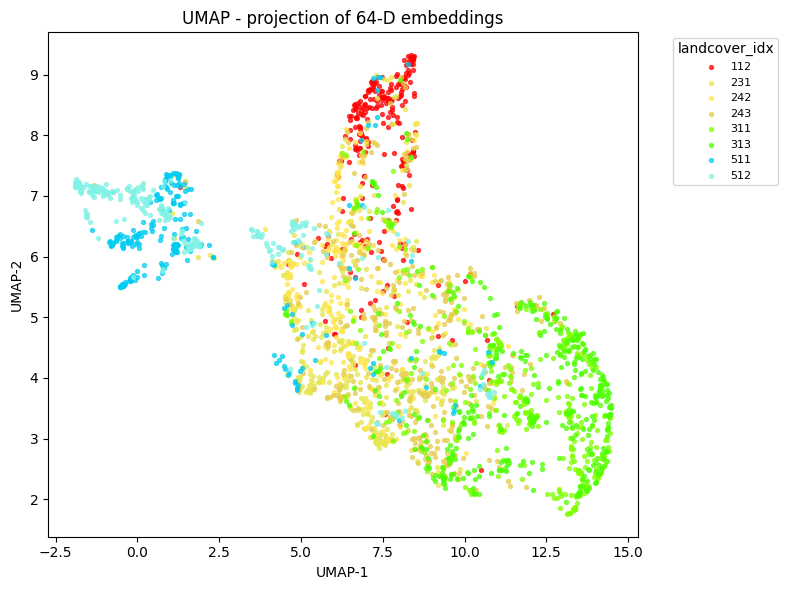

In [15]:
classes = np.sort(df_umap["landcover_idx"].unique())
num_classes = len(classes)

# Map each class to its CORINE color
color_map = {}
for cls in classes:
    if cls in corine.codes:
        idx = corine.codes.index(cls)
        # Convert hex color to RGB tuple normalized to [0, 1]
        hex_color = corine.clc_palette[idx]
        rgb = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
        color_map[cls] = rgb
    else:
        # Fallback if class not in CORINE
        color_map[cls] = (0.5, 0.5, 0.5)

plt.figure(figsize=(8, 6))

for cls in classes:
    m = df_umap["landcover_idx"] == cls
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=8,
        alpha=0.7,
        c=[color_map[cls]],
        label=str(int(cls)),
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP - projection of 64-D embeddings")
plt.legend(title="landcover_idx", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


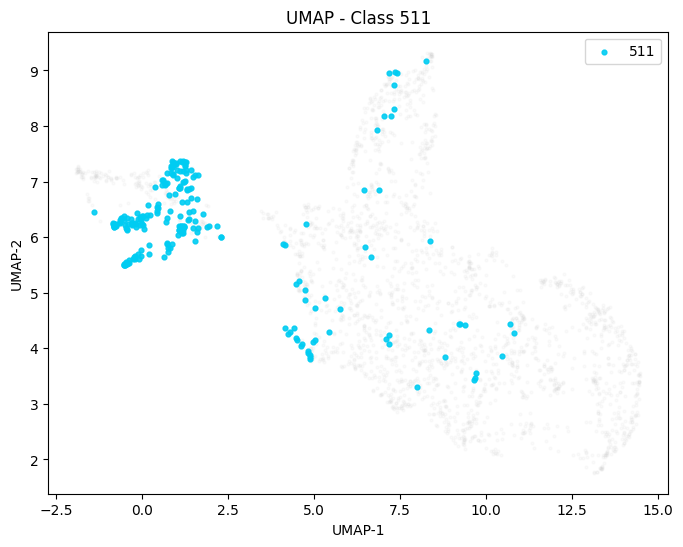

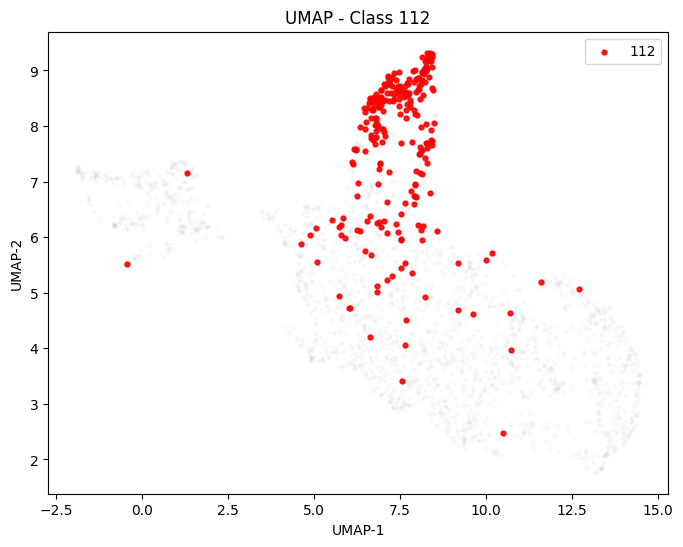

In [19]:
focus_classes = [511, 112]

# Map each class to its CORINE color (same approach as cell 13)
color_map_focus = {}
for cls in focus_classes:
    if cls in corine.codes:
        idx = corine.codes.index(cls)
        # Convert hex color to RGB tuple normalized to [0, 1]
        hex_color = corine.clc_palette[idx]
        rgb = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
        color_map_focus[cls] = rgb
    else:
        # Fallback if class not in CORINE
        color_map_focus[cls] = (0.5, 0.5, 0.5)

for cls in focus_classes:
    if cls not in df_umap["landcover_idx"].values:
        print(f"Class {cls} not in dataset, skipping.")
        continue

    m_focus = df_umap["landcover_idx"] == cls

    plt.figure(figsize=(8, 6))
    plt.scatter(
        df_umap.loc[~m_focus, "umap1"],
        df_umap.loc[~m_focus, "umap2"],
        s=4,
        alpha=0.1,
        c="lightgray",
    )
    plt.scatter(
        df_umap.loc[m_focus, "umap1"],
        df_umap.loc[m_focus, "umap2"],
        s=12,
        alpha=0.9,
        c=[color_map_focus[cls]],
        label=str(cls),
    )

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"UMAP - Class {cls}")
    plt.legend()
    plt.show()


In [21]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

def get_class_umap(cls):
    mask = df_umap["landcover_idx"] == cls
    Xc = df_umap.loc[mask, ["umap1", "umap2"]].values
    return Xc, mask

def _class_color(cls):
    # Prefer color_map from previous cell; fallback to classes/cmap
    if "color_map" in globals() and cls in color_map:
        return color_map[cls]
    if "classes" in globals() and "cmap" in globals():
        idx = np.where(classes == cls)[0]
        if len(idx):
            return cmap(int(idx[0]))
    return None

def plot_outliers(cls, mask, outlier_mask, title):
    plt.figure(figsize=(8, 6))

    # background
    plt.scatter(
        df_umap.loc[~mask, "umap1"],
        df_umap.loc[~mask, "umap2"],
        s=3,
        alpha=0.05,
        c="lightgray",
    )

    Xc = df_umap.loc[mask, ["umap1", "umap2"]].values
    color = _class_color(cls)

    # inliers
    plt.scatter(
        Xc[~outlier_mask, 0],
        Xc[~outlier_mask, 1],
        s=12,
        alpha=0.6,
        c=[color] if color is not None else None,
    )

    # outliers
    plt.scatter(
        Xc[outlier_mask, 0],
        Xc[outlier_mask, 1],
        s=40,
        alpha=0.95,
        marker="x",
        c=[color] if color is not None else None,
    )

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"{title} outlier detection")
    plt.show()

target_classes = [511, 112]


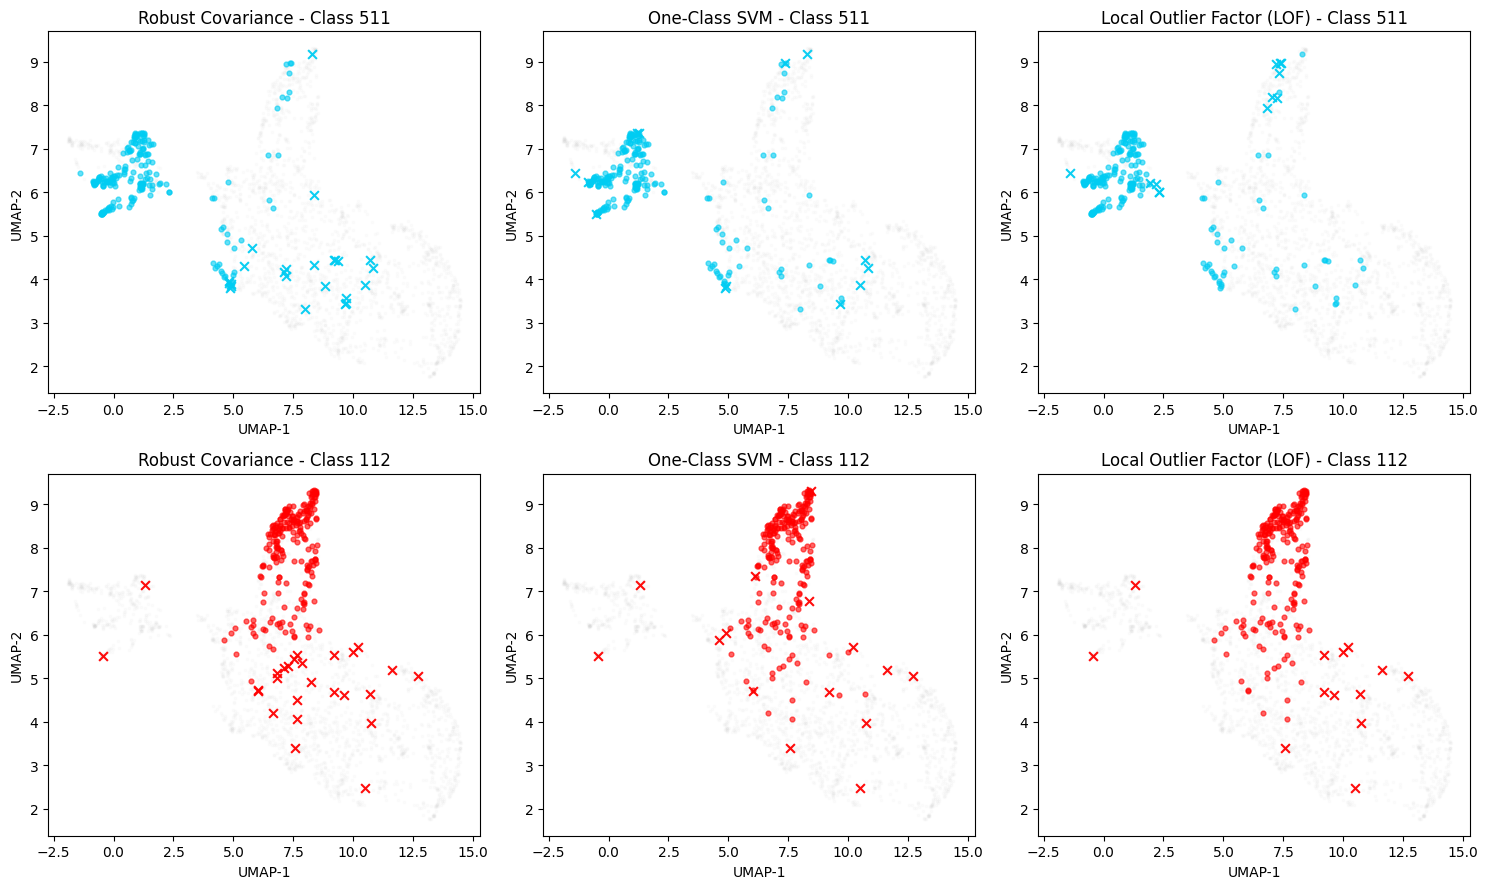

In [24]:
# Plot in 2x3 grid (transposed)
methods = ["Robust Covariance", "One-Class SVM", "Local Outlier Factor (LOF)"]
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for col, method in enumerate(methods):
    for row, cls in enumerate(target_classes):
        ax = axes[row, col]
        Xc, mask, outlier_mask = results[(method, cls)]
        color = _class_color(cls)

        # background
        ax.scatter(
            df_umap.loc[~mask, "umap1"],
            df_umap.loc[~mask, "umap2"],
            s=3,
            alpha=0.05,
            c="lightgray",
        )

        # inliers
        ax.scatter(
            Xc[~outlier_mask, 0],
            Xc[~outlier_mask, 1],
            s=12,
            alpha=0.6,
            c=[color] if color is not None else None,
        )

        # outliers
        ax.scatter(
            Xc[outlier_mask, 0],
            Xc[outlier_mask, 1],
            s=40,
            alpha=0.95,
            marker="x",
            c=[color] if color is not None else None,
        )

        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")
        ax.set_title(f"{method} - Class {cls}")

plt.tight_layout()
plt.show()


picked robust covariance

In [25]:
df_umap["RC_outlier"] = False

for cls in classes:

    Xc, mask = get_class_umap(cls)

    rc = EllipticEnvelope(contamination=contamination, random_state=42)
    rc.fit(Xc)

    pred = rc.predict(Xc)
    outliers = (pred == -1)

    df_umap.loc[mask, "RC_outlier"] = outliers

df_umap["RC_outlier"] = df_umap["RC_outlier"].astype(bool)
df_umap["RC_outlier"].value_counts()


RC_outlier
False    2252
True      252
Name: count, dtype: int64

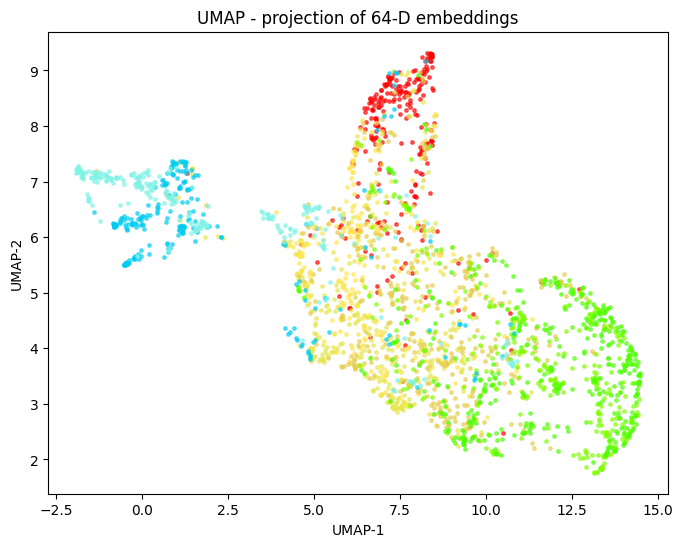

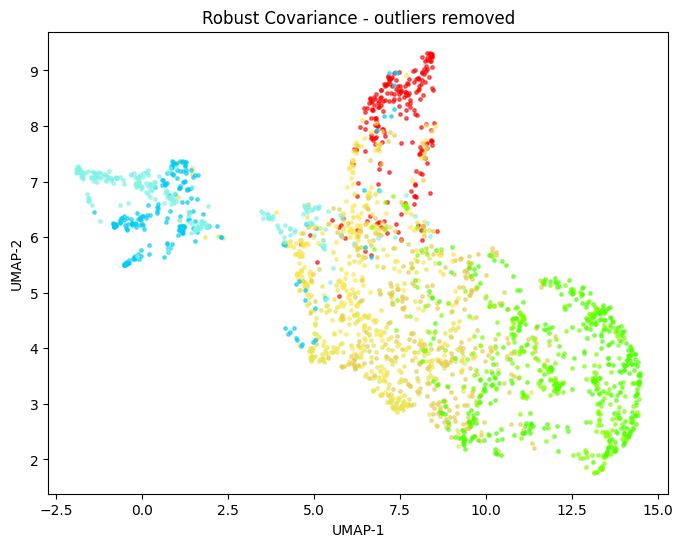

In [27]:
plt.figure(figsize=(8, 6))
for cls in classes:
    m = df_umap["landcover_idx"] == cls
    color = color_map[cls] if cls in color_map else (0.5, 0.5, 0.5)
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=6,
        alpha=0.6,
        c=[color],
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP - projection of 64-D embeddings")
plt.show()


plt.figure(figsize=(8, 6))
for cls in classes:
    m = (df_umap["landcover_idx"] == cls) & (~df_umap["RC_outlier"])
    color = color_map[cls] if cls in color_map else (0.5, 0.5, 0.5)
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=6,
        alpha=0.6,
        c=[color],
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Robust Covariance - outliers removed")
plt.show()
